In [1]:
!pip install tensorflow_addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
 !unzip Alzheimer.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: content/Alzheimer/test/Non_Demented/527.jpg  
  inflating: content/Alzheimer/test/Non_Demented/625.jpg  
  inflating: content/Alzheimer/test/Non_Demented/610.jpg  
  inflating: content/Alzheimer/test/Non_Demented/186.jpg  
  inflating: content/Alzheimer/test/Non_Demented/267.jpg  
  inflating: content/Alzheimer/test/Non_Demented/583.jpg  
  inflating: content/Alzheimer/test/Non_Demented/313.jpg  
  inflating: content/Alzheimer/test/Non_Demented/793.jpg  
  inflating: content/Alzheimer/test/Non_Demented/596.jpg  
  inflating: content/Alzheimer/test/Non_Demented/676.jpg  
  inflating: content/Alzheimer/test/Non_Demented/144.jpg  
  inflating: content/Alzheimer/test/Non_Demented/612.jpg  
  inflating: content/Alzheimer/test/Non_Demented/417.jpg  
  inflating: content/Alzheimer/test/Non_Demented/152.jpg  
  inflating: content/Alzheimer/test/Non_Demented/505.jpg  
  inflating: content/Alzheimer/test/Non_Demented/384.jpg  
  inflati

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input # DenseNet121


from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG # Data augmentation için
from tensorflow.keras.preprocessing import image


from tensorflow.keras.utils import to_categorical

from tensorflow.keras.utils import plot_model #Modeli çizmek için

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report # Confusion matrisi için
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.17.0


In [4]:
base_dir = "content/Alzheimer/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']


In [5]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
#Performing Image Augmentation to have more data samples
# Daha fazla veri örneğine sahip olmak için Image Augmentation gerçekleştirme

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 4800 images belonging to 4 classes.


In [7]:
# Bir batch veri alın
train_data, train_labels = next(train_data_gen)

# Veriyi kontrol edin
print(train_data.shape)
print(train_labels.shape)

(4800, 176, 176, 3)
(4800, 4)


In [8]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [9]:
densenet_model = DenseNet121(input_shape=(176, 176, 3), include_top=False, weights="imagenet")



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
for layer in densenet_model.layers:
    layer.trainable=False

In [11]:
custom_densenet_model = Sequential([
        densenet_model,
        Dropout(0.5),
        Flatten(),
        BatchNormalization(),
        Dense(521, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(521, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ], name = "densenet_cnn_model")

In [12]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
#Doğruluk %99'un üzerine çıktığında modelimizi eğitmeyi durdurmak için özel bir geri arama işlevi tanımlama

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)


In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import BatchNormalization

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [17]:
#Defining other parameters for our model

# Kullanılacak metrikler
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           F1Score()]

# Callbacks
CALLBACKS = [my_callback, rop_callback]

# Construct the model
model = custom_densenet_model # Create an instance of the model

model.build(input_shape=(None, 176, 176, 3))

model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model.summary()
# Check the shape of the data
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)


Model: "densenet_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25600)               │         102,400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 521)                 │      13,338,121 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 521)                 │           2,084 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 521)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 521)                 │         271,962 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 521)                 │           2,084 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 521)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,088 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,756,243 (79.18 MB)

 Trainable params: 13,665,455 (52.13 MB)

 Non-trainable params: 7,090,788 (27.05 MB)

Training data shape: (3072, 176, 176, 3)
Training labels shape: (3072, 4)
Validation data shape: (768, 176, 176, 3)
Validation labels shape: (768, 4)


In [18]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_densenet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - acc: 0.3819 - auc: 0.6243 - f1_score: 0.8478 - loss: 2.0470 - val_acc: 0.6328 - val_auc: 0.8372 - val_f1_score: 0.9237 - val_loss: 1.0230
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - acc: 0.5720 - auc: 0.8218 - f1_score: 0.9000 - loss: 1.1353 - val_acc: 0.6419 - val_auc: 0.8611 - val_f1_score: 0.9203 - val_loss: 1.0090
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - acc: 0.6411 - auc: 0.8748 - f1_score: 0.9217 - loss: 0.9058 - val_acc: 0.6914 - val_auc: 0.8905 - val_f1_score: 0.9343 - val_loss: 0.8958
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - acc: 0.7017 - auc: 0.9139 - f1_score: 0.9354 - loss: 0.7230 - val_acc: 0.7018 - val_auc: 0.9083 - val_f1_score: 0.9257 - val_loss: 0.7713
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - acc: 0.7486 - auc: 0.9306 - f1_score: 0.9424 - loss: 0.6355 - val_acc: 0.7201 - val_auc: 0.9152 - val_f1_score: 0.9343 - val_loss: 0.7359
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━

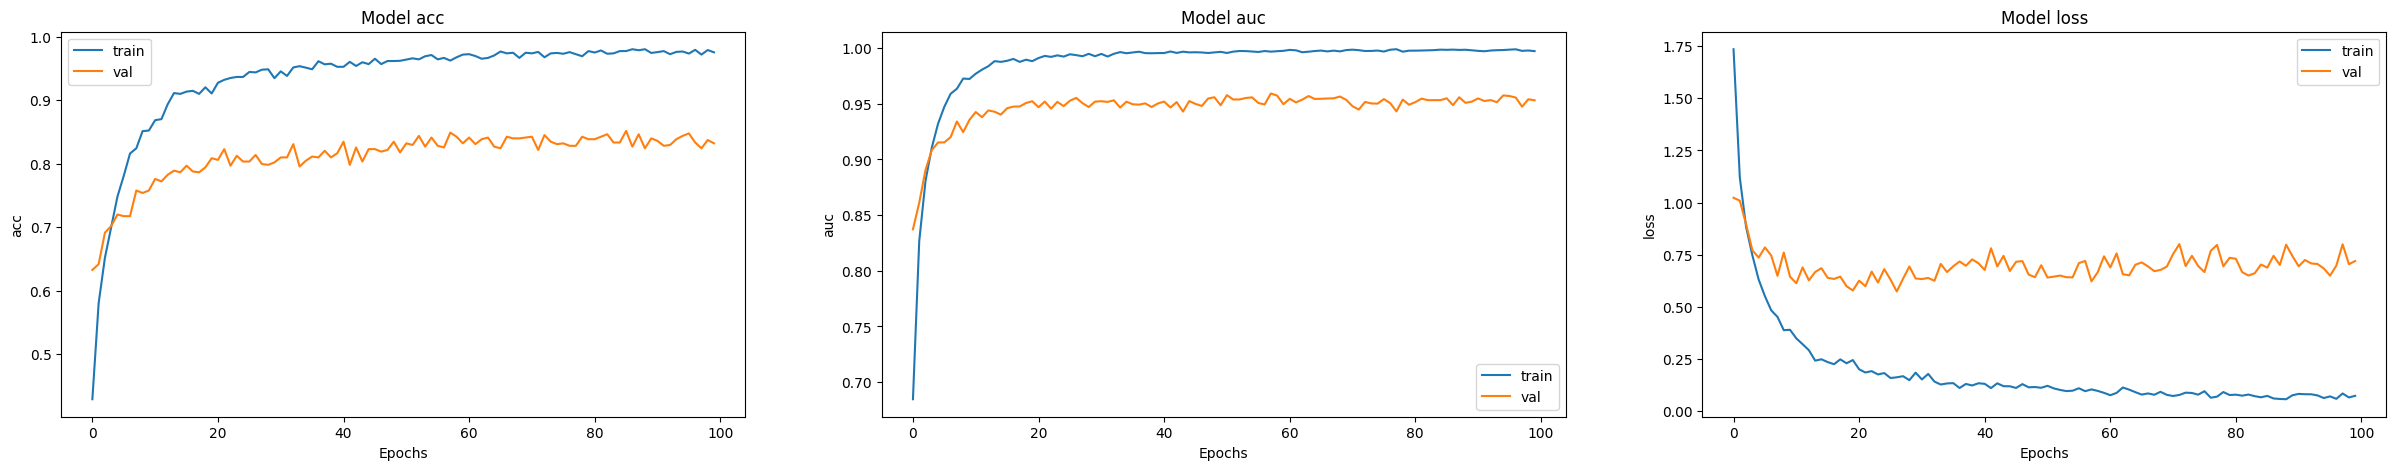

In [19]:
#Plotting the trend of the metrics during training
#Eğitim sırasındaki metriklerin (accuracy, auc, loss) eğilimlerini çizme

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
#Evaluating the model on the data
#Modelin veriler üzerinden değerlendirilmesi

train_scores = custom_densenet_model.evaluate(train_data, train_labels)
val_scores = custom_densenet_model.evaluate(val_data, val_labels)
test_scores = custom_densenet_model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - acc: 1.0000 - auc: 1.0000 - f1_score: 1.0000 - loss: 3.7491e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.8373 - auc: 0.9536 - f1_score: 0.9673 - loss: 0.6867
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - acc: 0.8203 - auc: 0.9451 - f1_score: 0.9578 - loss: 0.7977
Training Accuracy: 100.00%
Validation Accuracy: 83.20%
Testing Accuracy: 84.38%


In [21]:
#Predicting the test data
#Test verisini tahmin etme

pred_labels = custom_densenet_model.predict(test_data)

30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step


In [22]:
#Print the classification report of the tested data
#Test edilmiş verilerin sınıflandırma raporlarını yazdırma

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.91      0.75      0.82       156
VeryMildDemented       1.00      0.60      0.75        10
    MildDemented       0.83      0.94      0.88       467
ModerateDemented       0.83      0.76      0.80       327

       micro avg       0.84      0.84      0.84       960
       macro avg       0.89      0.76      0.81       960
    weighted avg       0.85      0.84      0.84       960
     samples avg       0.84      0.84      0.84       960



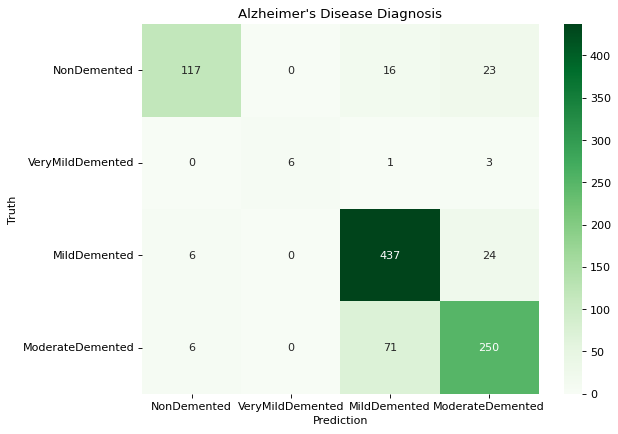

In [23]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [24]:
#Saving the model for future use
import os # Import the os module
work_dir = "Dataset/"
model_dir = work_dir + "alzheimer_desnet_model.keras"

# Create the directory if it doesn't exist
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

custom_densenet_model.save(model_dir)
os.listdir(work_dir)

['alzheimer_desnet_model.keras']